In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from scipy import optimize
from scipy.optimize import LinearConstraint
from scipy.optimize import NonlinearConstraint 
from scipy.optimize import minimize
from scipy.integrate import solve_ivp
from scipy.spatial.distance import cdist
from importlib import reload
import class_flp 
import utils
import time
import random
import pickle
import math

### Create multiple constrained FLP instances

In [2]:
n_instances = 2
N_range = [int(100+100*n) for n in range(n_instances)]
M_range = [int(3+0.5*m) for m in range(n_instances)]
cov_range = [3+2*p for p in range(n_instances)]
d = 2
scale = 20
seed = 12
N_range, M_range, cov_range

([100, 200], [3, 3], [3, 5])

In [3]:
# annealing parameters
beta0 = 1e-3
betaf = 1e2
beta_grow = 2

# Setting the coefficients for CBF CLF based optimization
alpha_h = 20
alpha_l = 20
p1 = 1
p2 = 10
gamma = 20
u_b = 0.0

# SGF
alpha = 1
kappa = 1

T_f = 10
dt_init = 0.05
dt_max = 0.1
dt_min = 1e-4
Ftol = 0.01 # same for SLSQP and SGF
xtol = 1e-3

# parameters for deterministic annealing based optimization
b1_min = 0.005
b1_max = 200
b1_grow = 5
theta = 5
n_iters = 1000
D_tol = 1e-4


### Generate multiple flp instances

In [4]:
flp_instances = []
for N, M, cov in zip(N_range, M_range, cov_range):
    demandLoc, Y0, demand_means, split_pct, rho = utils.generate_testcase(
    N, M, d, unif_split=False, cluster_cov=cov, seed=seed, sq_size=scale, normalizer=False)
    alloc_cost = np.random.uniform(1,1,(N,M))
    mean_alloc_cost = np.mean(alloc_cost)
    C = np.random.uniform(0.3,1,len(split_pct))
    C = (C/np.sum(C) + 0.02) * mean_alloc_cost
    B = np.random.uniform(C.min()*0.3, C.min()*0.6, len(split_pct))
    flp = class_flp.FLP(N, M, d, demandLoc, rho, C, B, alloc_cost, P_eps=1e-20, beta_tol=1e-10)
    flp_instances.append(flp)

/Users/dhananjaytiwari/Documents/NASA_ULI/CDC2025/CBF_MEP_based_constrained_Resource_Allocation/utils.py:101: RuntimeWarning: invalid value encountered in divide
  res_mean[i,:] = np.sum(resLoc[cnt:cnt+n_split, :], axis=0)/len(resLoc[cnt:cnt+n_split, :])


### Solve all the instaces using DA (unconstrained)

In [5]:
DA_sol_instances = []
for i, flp in enumerate(flp_instances):
    print(f'\n------instance:{i}------')
    Y0 = np.random.uniform(-scale, scale,(flp.M,flp.d))
    t0 = time.time()
    F_arr_da, b_arr_da, P_arr_da, Y_arr_da, t_compute_arr_da, cap_arr_da = flp.anneal_DA(Y0, beta0, betaf, beta_grow, n_iters=1000, D_tol=1e-5)
    t1 = time.time()
    sol_instance = {
        'M_name':'DA',
        'flp':flp,
        'F_arr':F_arr_da,
        'b_arr':b_arr_da,
        'P_arr':P_arr_da,
        'Y_arr':Y_arr_da,
        't_compute_arr':t_compute_arr_da,
        'cap_arr':cap_arr_da,
        'runtime':t1 - t0
    }
    DA_sol_instances.append(sol_instance)


------instance:0------
tolerance achieved: 	 norm_diff_D=1.358e-06
b:1.000e-03	F:27.0735
tolerance achieved: 	 norm_diff_D=2.089e-06
b:2.000e-03	F:27.0744
tolerance achieved: 	 norm_diff_D=2.102e-06
b:4.000e-03	F:27.0743
tolerance achieved: 	 norm_diff_D=6.170e-06
b:8.000e-03	F:27.0753
tolerance achieved: 	 norm_diff_D=9.658e-06
b:1.600e-02	F:27.0734
tolerance achieved: 	 norm_diff_D=9.690e-06
b:3.200e-02	F:24.1888
tolerance achieved: 	 norm_diff_D=8.213e-06
b:6.400e-02	F:15.6344
tolerance achieved: 	 norm_diff_D=9.846e-06
b:1.280e-01	F:9.9776
tolerance achieved: 	 norm_diff_D=7.370e-06
b:2.560e-01	F:6.8473
tolerance achieved: 	 norm_diff_D=8.724e-06
b:5.120e-01	F:5.0039
tolerance achieved: 	 norm_diff_D=6.316e-06
b:1.024e+00	F:3.9893
tolerance achieved: 	 norm_diff_D=4.668e-06
b:2.048e+00	F:3.4660
tolerance achieved: 	 norm_diff_D=3.149e-06
b:4.096e+00	F:3.2006
tolerance achieved: 	 norm_diff_D=3.983e-06
b:8.192e+00	F:3.0671
tolerance achieved: 	 norm_diff_D=4.160e-06
b:1.638e+01	F:2

### Solve using our CBF approach

In [6]:
CBF_sol_instances = []
for i, flp in enumerate(flp_instances):
    print(f'\n------instance:{i}------')
    Y0 = np.random.uniform(-scale, scale, (flp.M,flp.d))
    P0 = np.random.uniform(0.0,1,(flp.N, flp.M)) + flp.P_eps
    P0 = P0/P0.sum(axis=1,keepdims=True)
    x0 = utils.YP2x(Y0, P0); print(f'x0\tshape:{x0.shape}')

    t0 = time.time()
    F_arr_cbf, b_arr_cbf, P_arr_cbf, Y_arr_cbf, t_compute_arr_cbf, cap_arr_cbf = flp.anneal_CBF_CLF(
        x0, beta0, betaf, beta_grow, p1, p2, gamma, 
        alpha_h, alpha_l, T_f, dt_init, dt_min, dt_max, 
        Ftol, xtol, allowPrint=True, printOptimizeIters=False)
    t1 = time.time()

    sol_instance = {
        'M_name':'Our',
        'flp':flp,
        'F_arr':F_arr_cbf,
        'b_arr':b_arr_cbf,
        'P_arr':P_arr_cbf,
        'Y_arr':Y_arr_cbf,
        't_compute_arr':t_compute_arr_cbf,
        'cap_arr':cap_arr_cbf,
        'runtime':t1-t0
    }
    CBF_sol_instances.append(sol_instance)


/Users/dhananjaytiwari/Library/Python/3.9/lib/python/site-packages/cvxpy/expressions/expression.py:497: FutureWarning: 
    You didn't specify the order of the flatten expression. The default order
    used in CVXPY is Fortran ('F') order. This default will change to match NumPy's
    default order ('C') in a future version of CVXPY.
    To suppress this warning, please specify the order explicitly.
    
  warnings.warn(flatten_order_warning, FutureWarning)



------instance:0------
x0	shape:(306,)
beta:2.000e-03	F:4.522e+01
beta:4.000e-03	F:3.639e+01
beta:8.000e-03	F:3.153e+01
beta:1.600e-02	F:2.934e+01
beta:3.200e-02	F:2.809e+01
beta:6.400e-02	F:2.500e+01
beta:1.280e-01	F:1.785e+01
beta:2.560e-01	F:1.492e+01
beta:5.120e-01	F:1.054e+01
beta:1.024e+00	F:8.810e+00
beta:2.048e+00	F:7.926e+00
beta:4.096e+00	F:7.411e+00
beta:8.192e+00	F:7.152e+00
beta:1.638e+01	F:7.019e+00
beta:3.277e+01	F:6.947e+00
beta:6.554e+01	F:6.910e+00
beta:1.311e+02	F:6.890e+00

------instance:1------
x0	shape:(606,)
beta:2.000e-03	F:2.878e+01
beta:4.000e-03	F:2.796e+01
beta:8.000e-03	F:2.756e+01
beta:1.600e-02	F:2.740e+01
beta:3.200e-02	F:2.731e+01
beta:6.400e-02	F:2.723e+01
beta:1.280e-01	F:1.874e+01
beta:2.560e-01	F:1.401e+01
beta:5.120e-01	F:1.108e+01
beta:1.024e+00	F:9.441e+00
beta:2.048e+00	F:8.455e+00
beta:4.096e+00	F:7.942e+00
beta:8.192e+00	F:7.716e+00
beta:1.638e+01	F:7.530e+00
beta:3.277e+01	F:7.456e+00
beta:6.554e+01	F:7.417e+00
beta:1.311e+02	F:7.393e+00


### Solve using SGF approach

In [7]:
SGF_sol_instances = []
for i, flp in enumerate(flp_instances):
    print(f'\n------instance:{i}------')
    Y0 = np.random.uniform(-scale, scale,(flp.M,flp.d))
    P0 = np.random.uniform(0.0,1,(flp.N, flp.M)) + flp.P_eps
    P0 = P0/P0.sum(axis=1,keepdims=True)
    x0 = utils.YP2x(Y0, P0); print(f'x0\tshape:{x0.shape}')

    t0 = time.time()
    F_arr_sgf, b_arr_sgf, P_arr_sgf, Y_arr_sgf, t_compute_arr_sgf, cap_arr_sgf = flp.anneal_SGF(
        x0, beta0, betaf, beta_grow, alpha, kappa, T_f, dt_init, dt_min, dt_max, Ftol, xtol, allowPrint=True, printOptimizeIters=False)
    t1 = time.time()

    sol_instance = {
        'M_name':'SGF'
        'flp':flp,
        'F_arr':F_arr_sgf,
        'b_arr':b_arr_sgf,
        'P_arr':P_arr_sgf,
        'Y_arr':Y_arr_sgf,
        't_compute_arr':t_compute_arr_sgf,
        'cap_arr':cap_arr_sgf,
        'runtime':t1-t0
    }
    SGF_sol_instances.append(sol_instance)




------instance:0------
x0	shape:(306,)
beta:2.000e-03	F:4.547e+01
beta:4.000e-03	F:3.613e+01
beta:8.000e-03	F:3.165e+01
beta:1.600e-02	F:2.939e+01
beta:3.200e-02	F:2.824e+01
beta:6.400e-02	F:2.766e+01
beta:1.280e-01	F:2.737e+01
beta:2.560e-01	F:2.722e+01
beta:5.120e-01	F:2.714e+01
beta:1.024e+00	F:2.710e+01
beta:2.048e+00	F:2.708e+01
beta:4.096e+00	F:8.740e+00
beta:8.192e+00	F:7.573e+00
beta:1.638e+01	F:7.477e+00
beta:3.277e+01	F:7.425e+00
beta:6.554e+01	F:7.394e+00
beta:1.311e+02	F:7.377e+00

------instance:1------
x0	shape:(606,)
beta:2.000e-03	F:2.873e+01
beta:4.000e-03	F:2.800e+01
beta:8.000e-03	F:2.764e+01
beta:1.600e-02	F:2.747e+01
beta:3.200e-02	F:2.736e+01
beta:6.400e-02	F:2.731e+01
beta:1.280e-01	F:2.728e+01
beta:2.560e-01	F:2.726e+01
beta:5.120e-01	F:2.725e+01
beta:1.024e+00	F:2.724e+01
beta:2.048e+00	F:2.726e+01
beta:4.096e+00	F:2.725e+01
beta:8.192e+00	F:2.724e+01
beta:1.638e+01	F:2.724e+01
beta:3.277e+01	F:2.723e+01
beta:6.554e+01	F:2.723e+01
beta:1.311e+02	F:2.723e+01


### Solve using SLSQP

In [8]:
SLSQP_sol_instances = []
for i, flp in enumerate(flp_instances):
    print(f'\n------instance:{i}------')
    Y0 = np.random.uniform(-scale, scale,(flp.M,flp.d))
    P0 = np.random.uniform(0.0,1,(flp.N, flp.M)) + flp.P_eps
    P0 = P0/P0.sum(axis=1,keepdims=True)
    x0 = utils.YP2x(Y0, P0); print(f'x0\tshape:{x0.shape}')

    t0 = time.time()
    F_arr_slsqp, b_arr_slsqp, P_arr_slsqp, Y_arr_slsqp, t_compute_arr_slsqp, cap_arr_slsqp = flp.anneal_SLSQP(
        x0, beta0, betaf, beta_grow, Ftol)
    t1 = time.time()

    sol_instance = {
        'M_name':'SLSQP',
        'flp':flp,
        'F_arr':F_arr_slsqp,
        'b_arr':b_arr_slsqp,
        'P_arr':P_arr_slsqp,
        'Y_arr':Y_arr_slsqp,
        't_compute_arr':t_compute_arr_slsqp,
        'cap_arr':cap_arr_slsqp,
        'runtime':t1-t0
    }
    SLSQP_sol_instances.append(sol_instance)




------instance:0------
x0	shape:(306,)
beta:2.000e-03	F:4.474e+01
beta:4.000e-03	F:3.609e+01
beta:8.000e-03	F:3.158e+01
beta:1.600e-02	F:2.933e+01
beta:3.200e-02	F:2.820e+01
beta:6.400e-02	F:2.764e+01
beta:1.280e-01	F:2.735e+01
beta:2.560e-01	F:2.721e+01
beta:5.120e-01	F:1.025e+01
beta:1.024e+00	F:8.261e+00
beta:2.048e+00	F:6.133e+00
beta:4.096e+00	F:5.582e+00
beta:8.192e+00	F:5.256e+00
beta:1.638e+01	F:5.098e+00
beta:3.277e+01	F:5.037e+00
beta:6.554e+01	F:5.005e+00
beta:1.311e+02	F:4.990e+00

------instance:1------
x0	shape:(606,)
beta:2.000e-03	F:2.871e+01
beta:4.000e-03	F:2.795e+01
beta:8.000e-03	F:2.759e+01
beta:1.600e-02	F:2.740e+01
beta:3.200e-02	F:2.731e+01
beta:6.400e-02	F:2.726e+01
beta:1.280e-01	F:2.724e+01
beta:2.560e-01	F:2.722e+01
beta:5.120e-01	F:1.293e+01
beta:1.024e+00	F:1.116e+01
beta:2.048e+00	F:9.561e+00
beta:4.096e+00	F:9.010e+00
beta:8.192e+00	F:8.656e+00
beta:1.638e+01	F:8.516e+00
beta:3.277e+01	F:8.457e+00
beta:6.554e+01	F:8.425e+00
beta:1.311e+02	F:8.409e+00


### Solve using penalty based DA (DA-P)

In [9]:
DAC_sol_instances = []
for i, flp in enumerate(flp_instances):
    print(f'\n------instance:{i}------')
    Y0 = np.random.uniform(-scale, scale,(flp.M,flp.d))

    t0 = time.time()
    F_arr_dac, b_arr_dac, P_arr_dac, Y_arr_dac, t_compute_arr_dac, cap_arr_dac = flp.anneal_DA_C(
        Y0, beta0, betaf, beta_grow, b1_min, b1_max, b1_grow, theta, n_iters, D_tol)
    t1 = time.time()

    sol_instance = {
        'M_name':'DAP'
        'flp':flp,
        'F_arr':F_arr_dac,
        'b_arr':b_arr_dac,
        'P_arr':P_arr_dac,
        'Y_arr':Y_arr_dac,
        't_compute_arr':t_compute_arr_dac,
        'cap_arr':cap_arr_dac,
        'runtime':t1-t0
    }
    DAC_sol_instances.append(sol_instance)




------instance:0------
cons_violation: [-0.098  0.086 -0.048]
b:2.000e-03	b1_min,b1_max:(1e-05, 0.001)	F:27.0723
cons_violation: [-0.098  0.085 -0.048]
b:4.000e-03	b1_min,b1_max:(2e-05, 0.002)	F:27.0723
cons_violation: [-0.096  0.084 -0.047]
b:8.000e-03	b1_min,b1_max:(4e-05, 0.004)	F:27.0723
cons_violation: [-0.094  0.081 -0.046]
b:1.600e-02	b1_min,b1_max:(8e-05, 0.008)	F:27.0723
cons_violation: [-0.09   0.075 -0.044]
b:3.200e-02	b1_min,b1_max:(0.00016, 0.016)	F:27.0723
cons_violation: [-0.111  0.044  0.007]
b:6.400e-02	b1_min,b1_max:(0.00032, 0.032)	F:24.1857
cons_violation: [-0.149 -0.003  0.092]
b:1.280e-01	b1_min,b1_max:(0.00064, 0.064)	F:15.6344
cons_violation: [-0.139 -0.019  0.098]
b:2.560e-01	b1_min,b1_max:(0.00128, 0.128)	F:9.9765
cons_violation: [-0.121 -0.037  0.098]
b:5.120e-01	b1_min,b1_max:(0.00256, 0.256)	F:6.8555
cons_violation: [-0.106 -0.052  0.098]
b:1.024e+00	b1_min,b1_max:(0.00512, 0.512)	F:5.0049
cons_violation: [-0.102 -0.057  0.098]
b:2.048e+00	b1_min,b1_max:(0

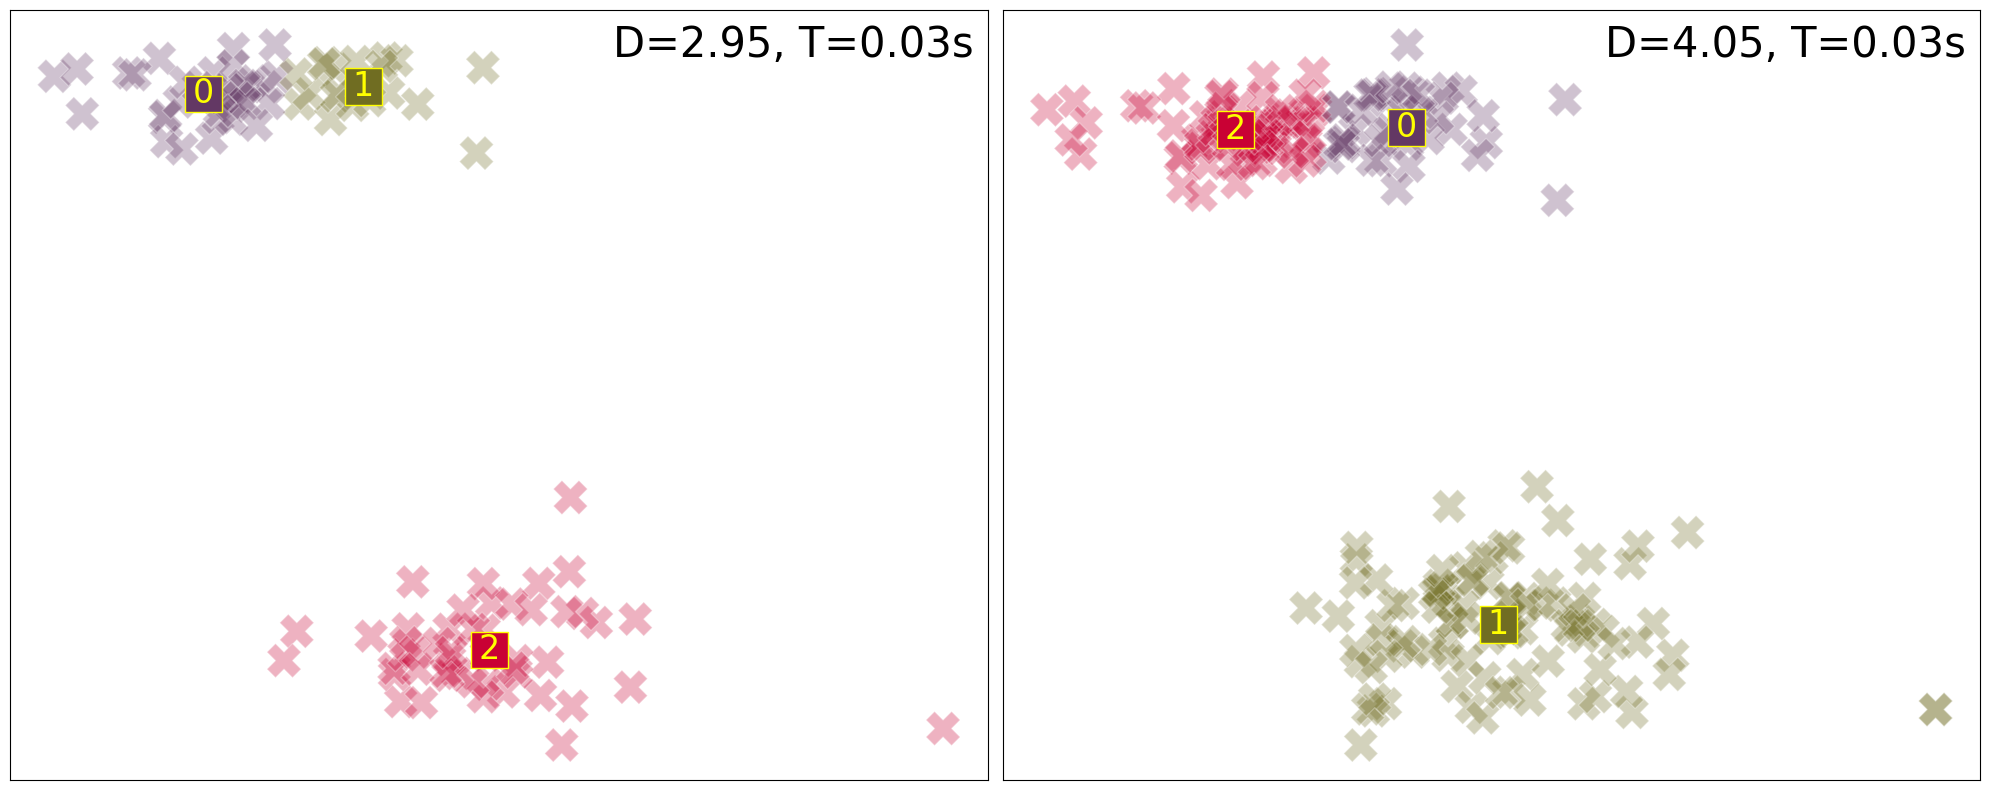

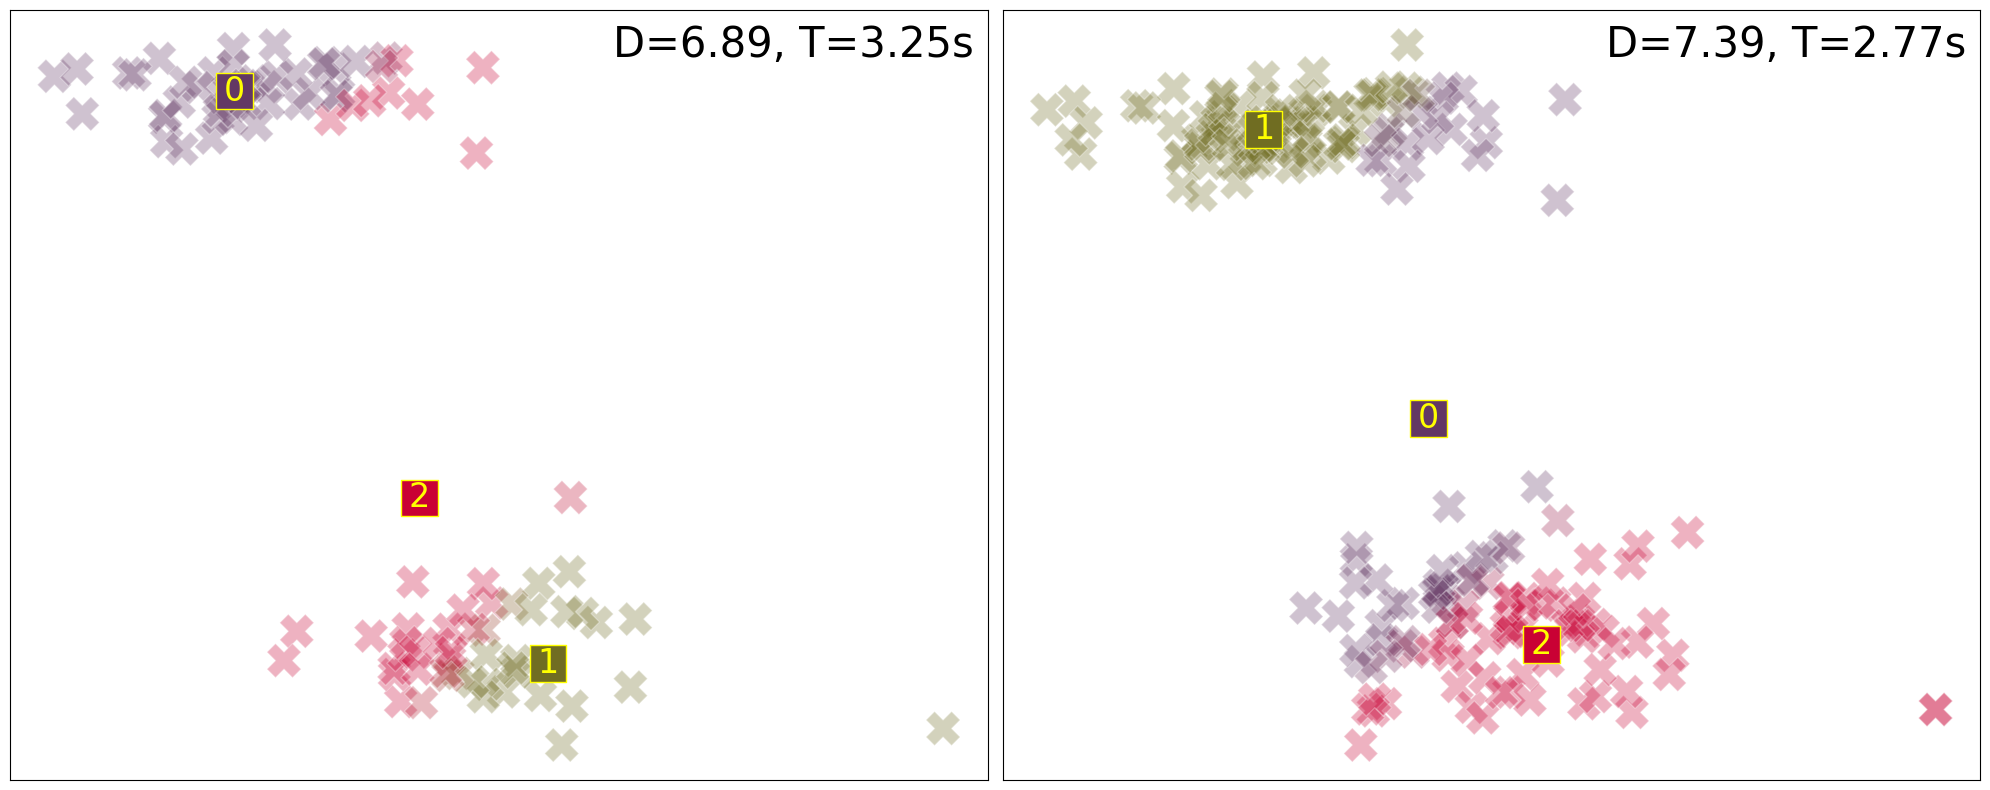

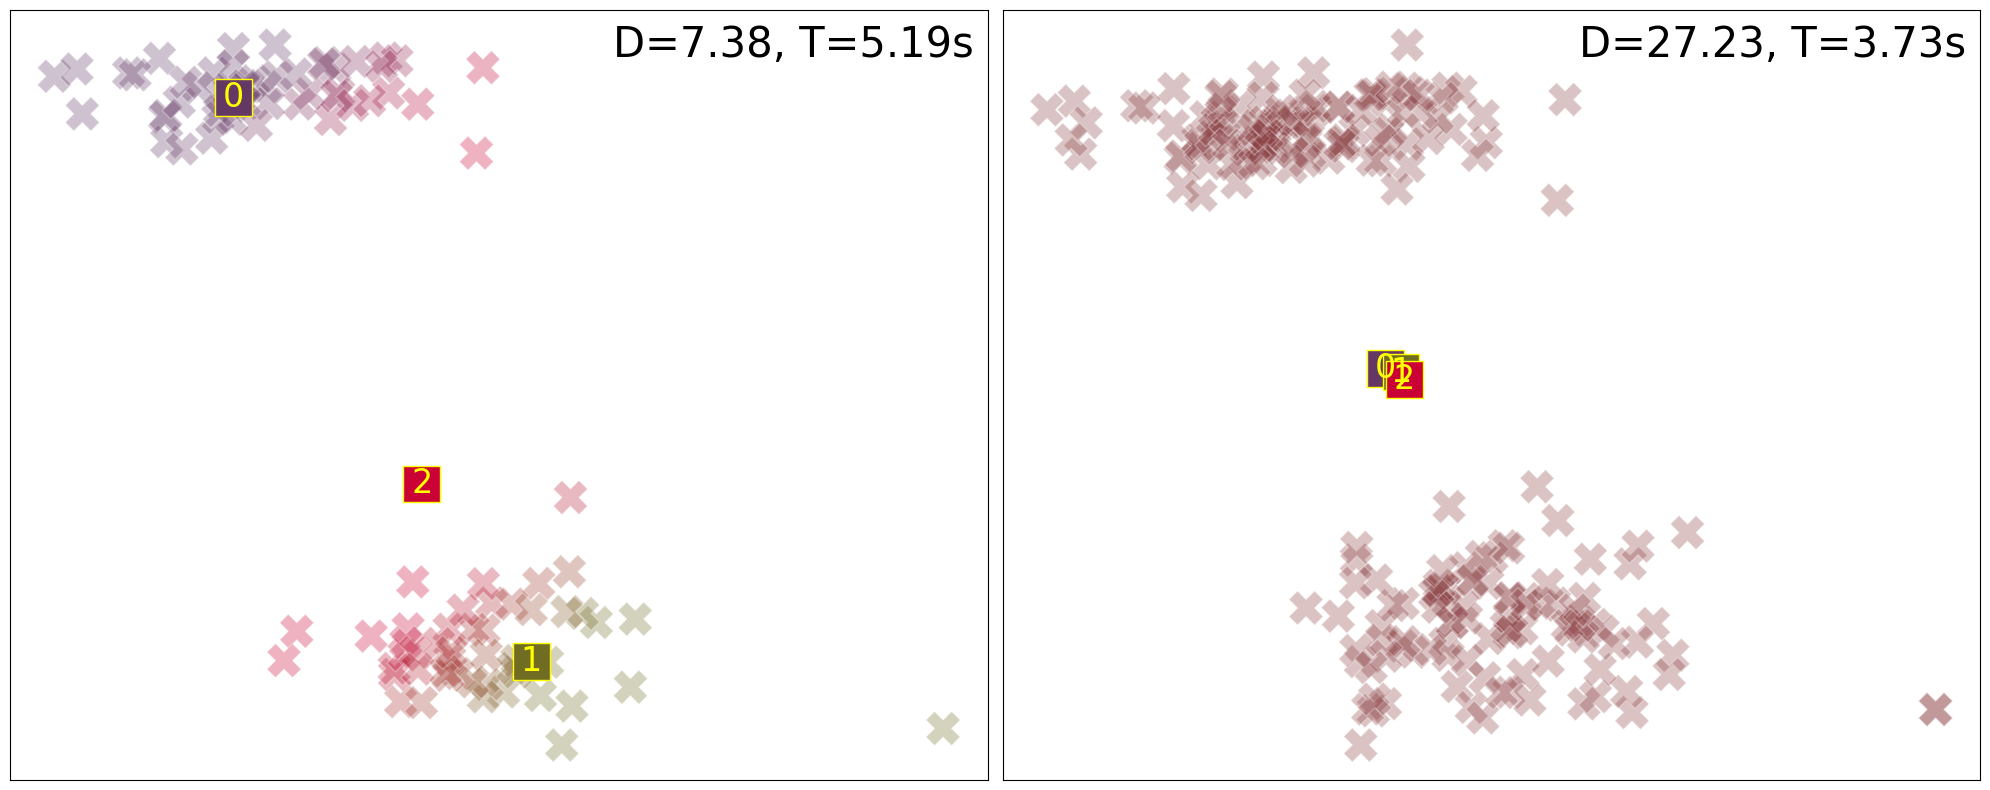

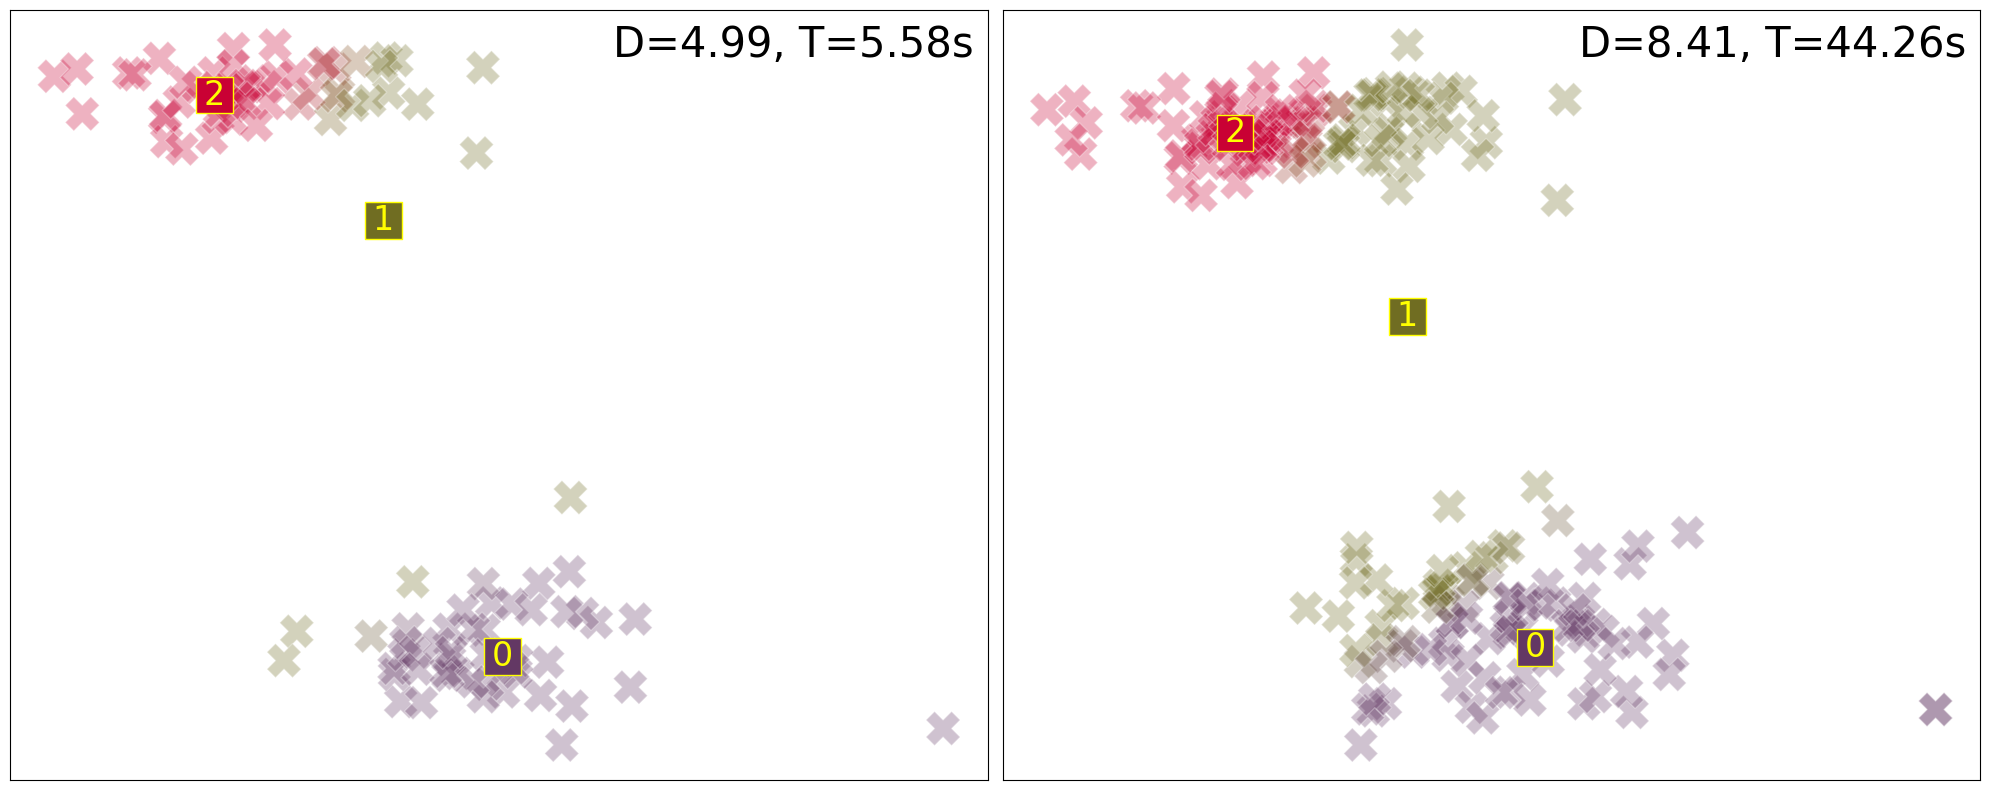

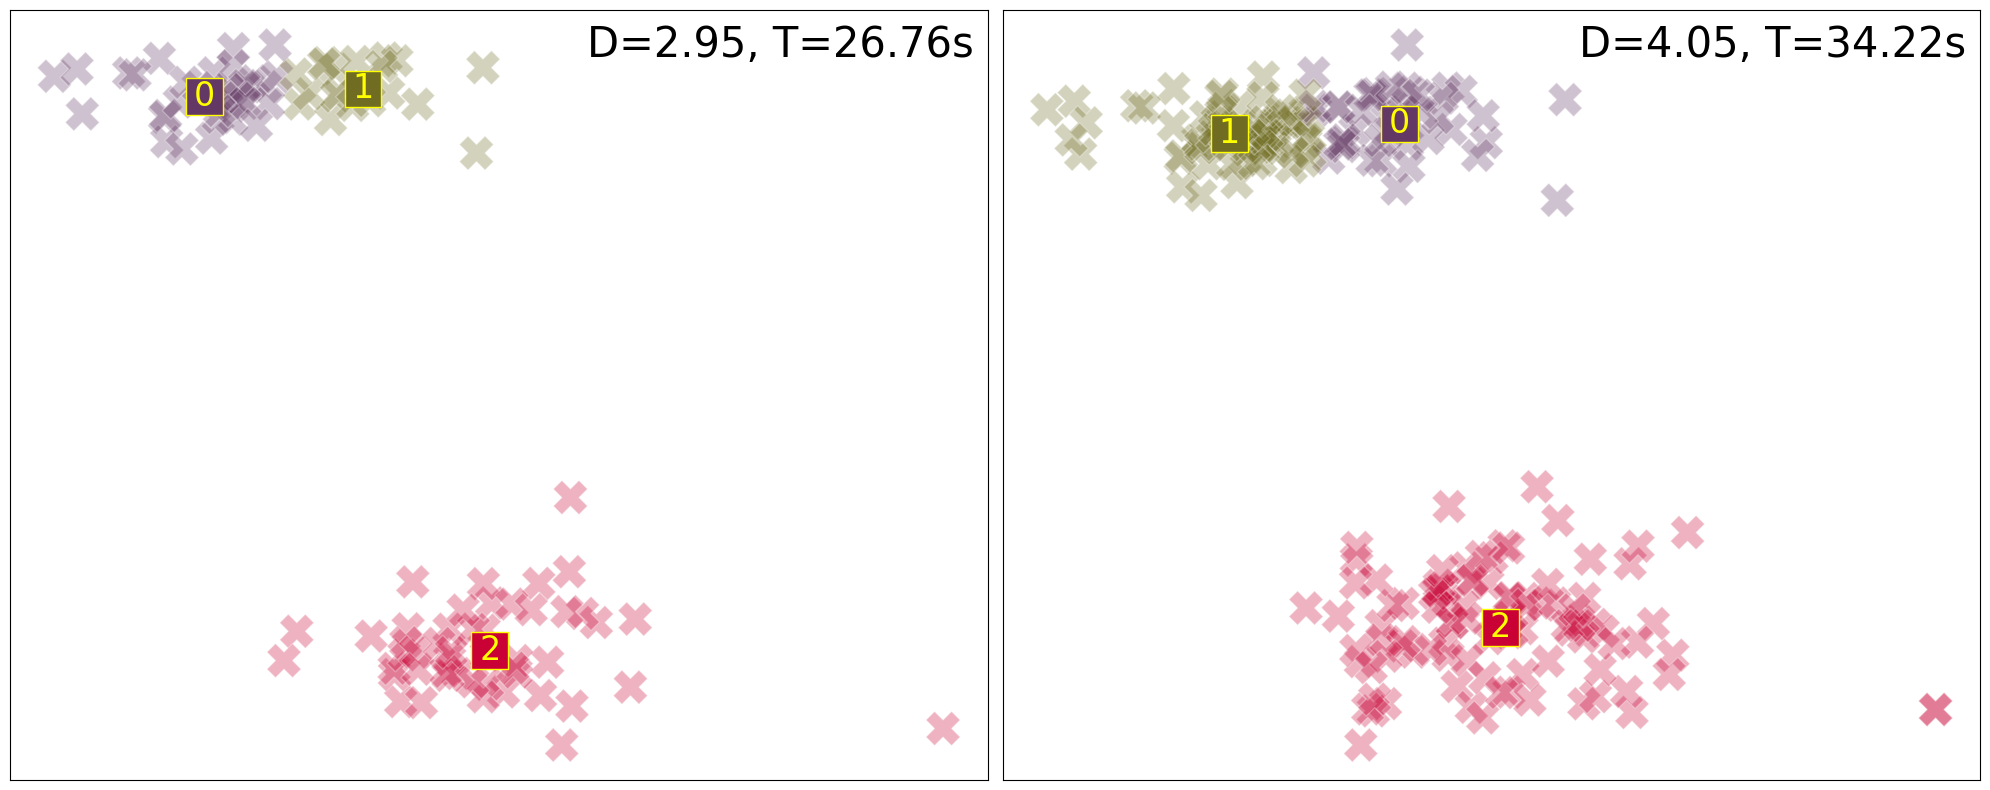

In [26]:
class_flp.plot_flp_sol_instances(
    DA_sol_instances,
    fontSize = 30,
    figSize = (20,8),
    plotResTraj = False
)

class_flp.plot_flp_sol_instances(
    CBF_sol_instances,
    fontSize = 30,
    figSize = (20,8),
    plotResTraj = False
)

class_flp.plot_flp_sol_instances(
    SGF_sol_instances,
    fontSize = 30,
    figSize = (20,8),
    plotResTraj = False
)

class_flp.plot_flp_sol_instances(
    SLSQP_sol_instances,
    fontSize = 30,
    figSize = (20,8),
    plotResTraj = False
)

class_flp.plot_flp_sol_instances(
    DAC_sol_instances,
    fontSize = 30,
    figSize = (20,8),
    plotResTraj = False
)

In [18]:
from collections import defaultdict

# Collect results by M_name and (M,N)
data = defaultdict(dict)
pairs = set()

for sol in DA_sol_instances:
    M_name = 'DA' #sol['M_name']
    flp = sol['flp']
    M, N = flp.M, flp.N
    final_cost = sol['F_arr'][-1]
    runtime = sol['runtime']

    data[M_name][(M, N)] = (final_cost, runtime)
    pairs.add((M, N))

# Sort (M,N) pairs for consistent column order
pairs = sorted(pairs)

# Build LaTeX tabular
header = " & " + " & ".join([f"\\multicolumn{{2}}{{c}}{{({N},{M})}}" for (M, N) in pairs]) + " \\\\"
subheader = "Approach " + " & " + " & ".join(["Cost & Time" for _ in pairs]) + " \\\\"
hline = "\\hline"

rows = []
for M_name, results in data.items():
    row = [M_name]
    for (M, N) in pairs:
        if (M, N) in results:
            cost, runtime = results[(M, N)]
            row.append(f"{cost:.2f} & {runtime:.2f}")
        else:
            row.append("- & -")  # empty if missing
    rows.append(" & ".join(row) + " \\\\")

latex_table = "\\begin{tabular}{" + "l" + "cc" * len(pairs) + "}\n"
latex_table += header + "\n"
latex_table += subheader + "\n"
latex_table += hline + "\n"
latex_table += "\n".join(rows) + "\n"
latex_table += "\\end{tabular}"

print(latex_table)


\begin{tabular}{lcccc}
 & \multicolumn{2}{c}{(100,3)} & \multicolumn{2}{c}{(200,3)} \\
Approach  & Cost & Time & Cost & Time \\
\hline
DA & 2.95 & 0.05 & 4.05 & 0.03 \\
\end{tabular}
